In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets , models, transforms
from urllib import *
url = './data'

In [2]:
#using GPU
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [3]:
transform = transforms.Compose([transforms.Resize((32,32)), #make sure it is 32
                                transforms.RandomHorizontalFlip(), #data augumenting
                                transforms.RandomRotation(10), #10 is degree
                                transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),#shear flip our pictures a little
                                #scale zoom in or out our pictures in the range we defined randomly
                                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5) , (0.5,0.5,0.5))]) #3 channels, in MNIST wehad 1 channel
                                #dont forget commas and the end
    
training_dataset = datasets.CIFAR10(root = './data', train = True , download = True , transform = transform)
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size = 100, shuffle = True)

validation_dataset = datasets.CIFAR10(root = './data' , train = False , download = True , transform = transform)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100 , shuffle = False)

training_dataset
validation_dataset

#(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Files already downloaded and verified
Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               RandomAffine(degrees=(0, 0), scale=(0.8, 1.2), shear=(-10, 10))
               ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.8, 1.2], hue=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [4]:
training_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               RandomAffine(degrees=(0, 0), scale=(0.8, 1.2), shear=(-10, 10))
               ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.8, 1.2], hue=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [5]:
#converting tensor into numpy array
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) #for 32,32,1
    image = image.clip(0,1)
    return image

In [6]:
#CIFAR10 classes in order
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

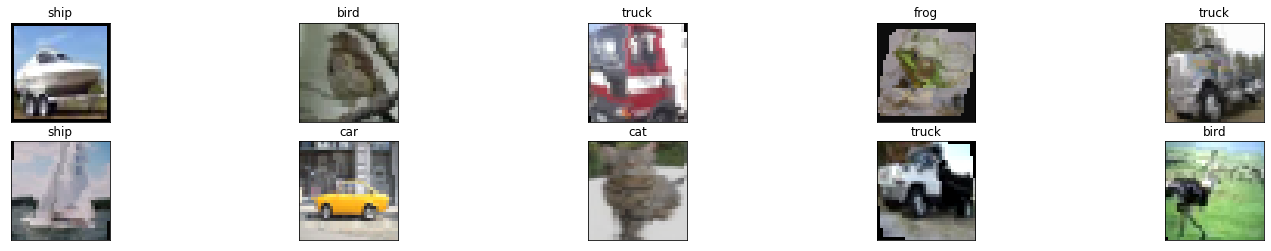

In [16]:
dataiter = iter(training_loader) #make sure you are using training loader not training dataset



images , labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
fig = plt.figure(figsize=(25,4))

for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[] , yticks= [])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()]) #classes cause it to print class name and not class number

In [8]:
#architecture

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1) #smaller kernel size cause avoiding overfitting=>3 ,
                                                       #padding is for including edges more efficently 
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
        self.conv3= nn.Conv2d(32, 64, 3, 1, padding=1) #increase number of layers to make it deeper in order to 
                                                       #gain better accuracy
        self.fc1 = nn.Linear(4*4*64, 500) #flatting it
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2) #2 for halfen it
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2) 
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2) 
        x = x.view(-1, 4*4*64) #flatting it
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x) #without Relu
        return x

In [9]:
model = LeNet().to(device) #GPU
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters() , lr = 0.001)#make sure lr is not very small

In [66]:
epochs = 10
train_loss_history = []
train_correct_history = []
validation_loss_history = []
validation_correct_history = []


for e in range(epochs):
    
    train_running_loss = 0.0
    train_running_correct = 0.0
    validation_running_loss = 0.0
    validation_running_correct = 0.0
    
    
    for inputs , labels in training_loader:
        inputs = inputs.to(device) #GPU
        labels = labels.to(device)
        
        outputs = model(inputs) #train
        
        loss = criterion(outputs, labels)#loss calculation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1) #classify
        
        train_running_loss += loss.item() #all losses in 1 epoch
        train_running_correct += torch.sum(preds == labels.data)
        
    else:
        with torch.no_grad():
            for validation_inputs, validation_labels in validation_loader:
                validation_inputs = validation_inputs.to(device)
                validation_labels = validation_labels.to(device)
                
                validation_outputs = model(validation_inputs)
                
                validation_loss = criterion(validation_outputs, validation_labels)
                _, validation_preds = torch.max(validation_outputs, 1)
                
                validation_running_loss += validation_loss.item()
                validation_running_correct += torch.sum(validation_preds == validation_labels.data)
                
        training_epoch_loss = train_running_loss/len(training_loader)
        training_epoch_correct = train_running_correct.float()/len(training_loader.dataset)
        validation_epoch_loss = validation_running_loss/len(validation_loader)
        validation_epoch_correct = validation_running_correct.float()/len(validation_loader.dataset)
        
        train_loss_history.append(training_epoch_loss)
        train_correct_history.append(training_epoch_correct)
        validation_loss_history.append(validation_epoch_loss)
        validation_correct_history.append(validation_epoch_correct)
        
        print("epoch: ",(e+1))
        print("training loss = {:.4f}  training accuracy {:.4f} ".format(training_epoch_loss, training_epoch_correct))
        print("validation loss = {:.4f} validation accuracy {:.4f}".format(validation_epoch_loss , validation_epoch_correct))
        print("==============================================================================")

epoch:  1
training loss = 1.7153  training accuracy 0.3682 
validation loss = 1.5081 validation accuracy 0.4489
epoch:  2
training loss = 1.4177  training accuracy 0.4869 
validation loss = 1.3505 validation accuracy 0.5043
epoch:  3
training loss = 1.3037  training accuracy 0.5339 
validation loss = 1.2351 validation accuracy 0.5606
epoch:  4
training loss = 1.2092  training accuracy 0.5679 
validation loss = 1.1862 validation accuracy 0.5749
epoch:  5
training loss = 1.1431  training accuracy 0.5959 
validation loss = 1.1301 validation accuracy 0.5967
epoch:  6
training loss = 1.0866  training accuracy 0.6151 
validation loss = 1.0590 validation accuracy 0.6264
epoch:  7
training loss = 1.0445  training accuracy 0.6319 
validation loss = 1.0836 validation accuracy 0.6168
epoch:  8
training loss = 1.0090  training accuracy 0.6442 
validation loss = 1.0325 validation accuracy 0.6387
epoch:  9
training loss = 0.9732  training accuracy 0.6558 
validation loss = 0.9856 validation accuracy

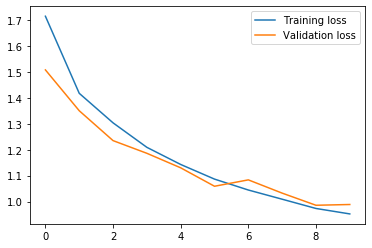

In [67]:
plt.plot(train_loss_history, label = 'Training loss')
plt.plot(validation_loss_history, label = 'Validation loss')
plt.legend() #to view both lines seprately

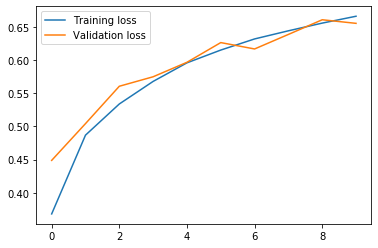

In [68]:
plt.plot(train_correct_history, label = 'Training loss')
plt.plot(validation_correct_history, label = 'Validation loss')
plt.legend() #to view both lines seprately

In [69]:
import PIL.ImageOps
import requests
from PIL import Image

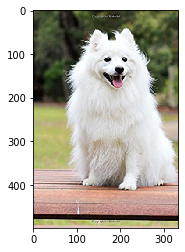

In [70]:
url1 = 'https://images-na.ssl-images-amazon.com/images/I/51cc84hBwRL._SX331_BO1,204,203,200_.jpg' #make sure your url is .png or .jpg
response = requests.get(url1, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

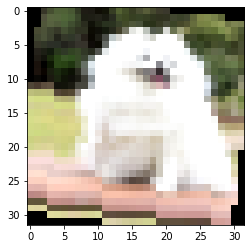

In [71]:
img = transform(img) 
plt.imshow(im_convert(img))

In [75]:
images = img.to(device).unsqueeze(0)
output = model(images)
_, pred = torch.max(output, 1)
print(classes[pred.item()])
#printing the class which our image belongs to

dog


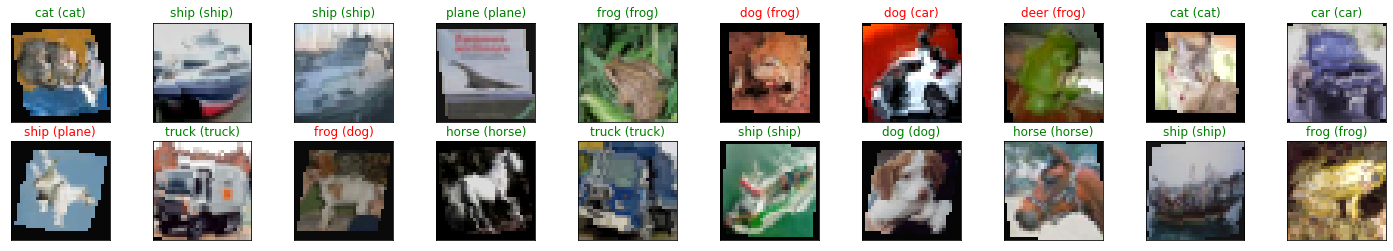

In [77]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), 
                                  str(classes[labels[idx].item()])), 
                                  color=("green" if preds[idx]==labels[idx] else "red"))
    #firs name is prediction and real labels correspond is in paranthisis